In [3]:
import glob
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from matplotlib.pyplot import cm
from pricing_benchmark import prob_def_quanto
from simulation import init_index_data, load_perp_params
import seaborn as sns
from matplotlib import font_manager

font_path = './inter/Inter Desktop/Inter-Regular.otf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

sns.set_style('whitegrid') # darkgrid, white grid, dark, white and ticks
# plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes


COLL = 'MATIC'
QUOTE = 'USD'



In [5]:
run_id = 8762580057492
nrows = None
stat = ["perp_margin", "perp_K2", "perp_L1", "perp_volume_qc", "amm_cash", "pool_margin", "staker_cash", "protocol_earnings_vault", "idx_px", "idx_s3", "df_cash"]

In [6]:


run_file = f"./results/sim_run_id_{run_id}.csv"
df_run = pd.read_csv(run_file)
sim_ids = df_run["Sim_ID"]
res = None
dtypes = {a: np.float64 for a in stat}
dtypes['time'] = pd.StringDtype()
usecols = stat + ["time"]
for i, sim_id in enumerate(sim_ids):
    sim_file = f"res[0-9]+-[0-9]+-[A-Z]+{QUOTE}{COLL}_[0-9]+-{sim_id}.csv"
    files = [f for f in os.listdir("./results/") if re.search(sim_file, f)]
    if len(files) == 0:
        print(f"Sim id {sim_id} not found for run id {run_id}.")
        continue
    amm_balance = 0
    for f in files:
        df_sim = pd.read_csv(f"./results/{f}", usecols=usecols, dtype=dtypes, nrows=nrows, low_memory=False) # 
        df_sim = df_sim.iloc[::(60*24)]
        if res is None:
            res = np.zeros((df_sim.shape[0], len(sim_ids), 5), dtype=np.float64, order="F")
        # all the liquidity in the protocol that is not trader-owned
        # amm balance at spot
        amm_balance += (df_sim['perp_margin'] + (df_sim['perp_K2'] * df_sim['idx_px'] - df_sim['perp_L1']) / df_sim['idx_s3']).values
        # res[:,i,0] = (df_sim['df_cash'] + df_sim['amm_cash'] + df_sim['pool_margin'] + df_sim['protocol_earnings_vault'] + df_sim['staker_cash']).values
        res[:,i,0] = (df_sim['df_cash'] + df_sim['amm_cash'] + df_sim['protocol_earnings_vault'] + df_sim['staker_cash']).values
        res[:,i,1] += df_sim['perp_volume_qc'].values
        res[:,i,2] = df_sim['idx_s3'].values
        res[:,i,4] = (df_sim['df_cash'] + df_sim['amm_cash'] + df_sim['protocol_earnings_vault']).values
    res[:,i,3] = amm_balance
    res[:,i,0] += amm_balance
    res[:,i,4] += amm_balance
    print(f"Loaded sim {sim_id} ({i+1}/{len(sim_ids)})")
    
res_old = np.copy(res)

Loaded sim -3597488734810713050 (1/81)
Loaded sim -2583676436372800641 (2/81)
Loaded sim 5761671432311651199 (3/81)
Loaded sim 1454429198571046553 (4/81)
Loaded sim 6866598879993327090 (5/81)
Loaded sim -7633154708016140814 (6/81)
Loaded sim -1811464360964554630 (7/81)
Loaded sim -797652062526642221 (8/81)
Loaded sim 7547695806157809619 (9/81)
Loaded sim -664053538737120205 (10/81)
Loaded sim 7395788048335649029 (11/81)
Loaded sim -2705608156689450747 (12/81)
Loaded sim -8328304481257089516 (13/81)
Loaded sim -2916134799834808979 (14/81)
Loaded sim 5429213068849642861 (15/81)
Loaded sim 6852546032916860917 (16/81)
Loaded sim 7866358331354773326 (17/81)
Loaded sim -2235037873670326450 (18/81)
Loaded sim -5450243051865647795 (19/81)
Loaded sim 7007955918191489567 (20/81)
Loaded sim -7491797669817978337 (21/81)
Loaded sim 4000032264500479936 (22/81)
Loaded sim 5013844562938392345 (23/81)
Loaded sim -5087551642086707431 (24/81)
Loaded sim -3664218678019489375 (25/81)
Loaded sim 17479510034

In [98]:
res = np.copy(res_old)

# drop first n days
drop = 90
res = res[drop:,:,:]
time_df = pd.to_datetime(df_sim['time'], format='%y-%m-%d %H:%M', utc=True).values #[::(60*12)]
time_df = time_df[drop:]

lps = res[:,:,0] - res[:,:,4] # total - protocol owned

print("Cumulative Stats:\n\n\n")
print(pd.DataFrame(
    {"Volume": res[:,:,1].flatten(), 
     "Gross Earnings": (res[:,:,0] * res[:,:,2]).flatten(), 
     "Protocol Earnings": (res[:,:,4] * res[:,:,2]).flatten(), 
     "Gross Earnings per Volume": ((res[:,:,0] * res[:,:,2]) / res[:,:,1]).flatten(), 
     "Protocol Earnings per Volume": ((res[:,:,4] * res[:,:,2]) / res[:,:,1]).flatten(), 
     "LP earnings per Volume": (lps * res[:,:,2] / res[:,:,1]).flatten()}
).describe())

res = np.copy(res_old)


# monthly volume and earnings
res[30:,:,0] = res[30:,:,0] - res[:-30,:,0] # gross earnings, coll ccy
res[30:,:,1] = res[30:,:,1] - res[:-30,:,1] # volume, quote ccy
res[30:,:,4] = res[30:,:,4] - res[:-30,:,4] # protocol earnings, coll ccy


# drop first n days
drop = 30
res = res[drop:,:,:]
time_df = pd.to_datetime(df_sim['time'], format='%y-%m-%d %H:%M', utc=True).values #[::(60*12)]
time_df = time_df[drop:]


print("\n\n\n---Stats for last 30 days---\n\n")

print(pd.DataFrame(
    {"Volume": res[:,:,1].flatten(), 
     "Gross Earnings": (res[:,:,0] * res[:,:,2]).flatten(), 
     "Protocol Earnings": (res[:,:,4] * res[:,:,2]).flatten(), 
     "Gross Earnings per Volume": ((res[:,:,0] * res[:,:,2]) / res[:,:,1]).flatten(),
     "Protocol Earnings per Volume": ((res[:,:,4] * res[:,:,2]) / res[:,:,1]).flatten(),
     "AMM Balance": (res[:,:,3] * res[:,:,2]).flatten()}
).describe())


Cumulative Stats:



             Volume  Gross Earnings  Protocol Earnings  \
count  7.533000e+03    7.533000e+03       7.533000e+03   
mean   1.650737e+09    3.801304e+06       3.597105e+06   
std    5.539528e+08    1.326585e+06       1.288071e+06   
min    6.093165e+08    1.529027e+06       1.432656e+06   
25%    1.223883e+09    2.792400e+06       2.617743e+06   
50%    1.590205e+09    3.482168e+06       3.275348e+06   
75%    2.030299e+09    4.522673e+06       4.288606e+06   
max    3.634709e+09    9.700828e+06       9.260568e+06   

       Gross Earnings per Volume  Protocol Earnings per Volume  \
count                7533.000000                   7533.000000   
mean                    0.002358                      0.002227   
std                     0.000511                      0.000494   
min                     0.001339                      0.001241   
25%                     0.001987                      0.001866   
50%                     0.002257                      0.0021

In [93]:
print(time_df[time_df >= pd.to_datetime("22-11-1 00:00", format='%y-%m-%d %H:%M')][0])
res_at_time = res[time_df >= pd.to_datetime("22-11-1 00:00", format='%y-%m-%d %H:%M'),:,:]
res_at_time = res_at_time[0,:,:]

print(pd.DataFrame(
    {"Volume": res_at_time[:,1].flatten(), 
     "Gross Earnings": (res_at_time[:,0] * res_at_time[:,2]).flatten(), 
     "Protocol Earnings": (res_at_time[:,4] * res_at_time[:,2]).flatten(), 
     "Gross Earnings per Volume": ((res_at_time[:,0] * res_at_time[:,2]) / res_at_time[:,1]).flatten(),
     "Protocol Earnings per Volume": ((res_at_time[:,4] * res_at_time[:,2]) / res_at_time[:,1]).flatten(),}
).describe())

2022-11-01T00:03:00.000000000
             Volume  Gross Earnings  Protocol Earnings  \
count  8.100000e+01    8.100000e+01       8.100000e+01   
mean   4.477004e+08    7.300400e+05       7.075466e+05   
std    1.016426e+08    3.907038e+05       3.860958e+05   
min    2.598562e+08    1.411524e+05       1.323474e+05   
25%    3.838770e+08    4.141138e+05       3.858081e+05   
50%    4.358504e+08    6.780308e+05       6.512212e+05   
75%    5.025612e+08    9.821754e+05       9.728750e+05   
max    8.232262e+08    1.813393e+06       1.771946e+06   

       Gross Earnings per Volume  Protocol Earnings per Volume  
count                  81.000000                     81.000000  
mean                    0.001683                      0.001632  
std                     0.000948                      0.000938  
min                     0.000373                      0.000325  
25%                     0.000964                      0.000904  
50%                     0.001439                      0.0

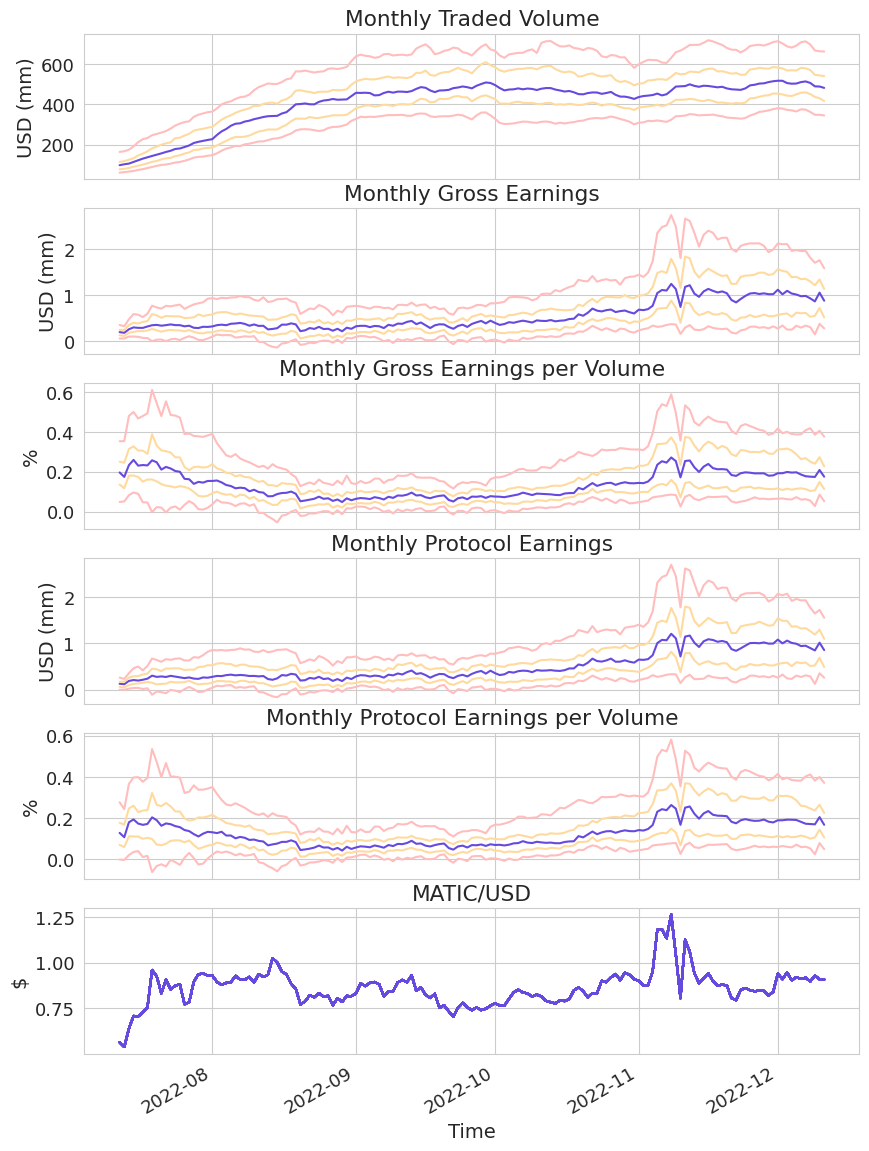

In [78]:

fig, axs = plt.subplots(6, 1, sharex=True)

axs[0].plot(time_df, 1e-6 * np.median(res[:,:,1], axis=-1), "-", color="#664ADF", linewidth=1.5, alpha=1)
axs[0].plot(time_df, 1e-6 * np.quantile(res[:,:,1], 0.75, axis=-1), "-", color="#FFDA9F", linewidth=1.5, alpha=1)
axs[0].plot(time_df, 1e-6 * np.quantile(res[:,:,1], 0.05, axis=-1), "-", color="#FFBDBD", linewidth=1.5, alpha=1)
axs[0].plot(time_df, 1e-6 * np.quantile(res[:,:,1], 0.25, axis=-1), "-", color="#FFDA9F", linewidth=1.5, alpha=1)
axs[0].plot(time_df, 1e-6 * np.quantile(res[:,:,1], 0.95, axis=-1), "-", color="#FFBDBD", linewidth=1.5, alpha=1)
axs[0].set_ylabel("USD (mm)")
axs[0].set_title("Monthly Traded Volume")

axs[1].plot(time_df, 1e-6 * np.median(res[:,:,0] * res[:,:,2], axis=-1), "-", color="#664ADF", linewidth=1.5, alpha=1)
axs[1].plot(time_df, 1e-6 * np.quantile(res[:,:,0] * res[:,:,2], 0.25, axis=-1), "-", color="#FFDA9F", linewidth=1.5, alpha=1)
axs[1].plot(time_df, 1e-6 * np.quantile(res[:,:,0] * res[:,:,2], 0.75, axis=-1), "-", color="#FFDA9F", linewidth=1.5, alpha=1)
axs[1].plot(time_df, 1e-6 * np.quantile(res[:,:,0] * res[:,:,2], 0.05, axis=-1), "-", color="#FFBDBD", linewidth=1.5, alpha=1)
axs[1].plot(time_df, 1e-6 * np.quantile(res[:,:,0] * res[:,:,2], 0.95, axis=-1), "-", color="#FFBDBD", linewidth=1.5, alpha=1)
axs[1].set_ylabel("USD (mm)")
axs[1].set_title("Monthly Gross Earnings")

axs[2].plot(time_df, 100 * np.median(res[:,:,0] * res[:,:,2] / res[:,:,1], axis=-1), "-", color="#664ADF", linewidth=1.5, alpha=1)
axs[2].plot(time_df, 100 * np.quantile(res[:,:,0] * res[:,:,2] / res[:,:,1], 0.25, axis=-1), "-", color="#FFDA9F", linewidth=1.5, alpha=1)
axs[2].plot(time_df, 100 *np.quantile(res[:,:,0] * res[:,:,2] / res[:,:,1], 0.75, axis=-1), "-", color="#FFDA9F", linewidth=1.5, alpha=1)
axs[2].plot(time_df, 100 * np.quantile(res[:,:,0] * res[:,:,2] / res[:,:,1], 0.05, axis=-1), "-", color="#FFBDBD", linewidth=1.5, alpha=1)
axs[2].plot(time_df, 100 *np.quantile(res[:,:,0] * res[:,:,2] / res[:,:,1], 0.95, axis=-1), "-", color="#FFBDBD", linewidth=1.5, alpha=1)
axs[2].set_ylabel("%")
axs[2].set_title("Monthly Gross Earnings per Volume")

axs[3].plot(time_df, 1e-6 * np.median(res[:,:,4] * res[:,:,2], axis=-1), "-", color="#664ADF", linewidth=1.5, alpha=1)
axs[3].plot(time_df, 1e-6 * np.quantile(res[:,:,4] * res[:,:,2], 0.25, axis=-1), "-", color="#FFDA9F", linewidth=1.5, alpha=1)
axs[3].plot(time_df, 1e-6 * np.quantile(res[:,:,4] * res[:,:,2], 0.75, axis=-1), "-", color="#FFDA9F", linewidth=1.5, alpha=1)
axs[3].plot(time_df, 1e-6 * np.quantile(res[:,:,4] * res[:,:,2], 0.05, axis=-1), "-", color="#FFBDBD", linewidth=1.5, alpha=1)
axs[3].plot(time_df, 1e-6 * np.quantile(res[:,:,4] * res[:,:,2], 0.95, axis=-1), "-", color="#FFBDBD", linewidth=1.5, alpha=1)
axs[3].set_ylabel("USD (mm)")
axs[3].set_title("Monthly Protocol Earnings")

axs[4].plot(time_df, 100 * np.median(res[:,:,4] * res[:,:,2] / res[:,:,1], axis=-1), "-", color="#664ADF", linewidth=1.5, alpha=1)
axs[4].plot(time_df, 100 * np.quantile(res[:,:,4] * res[:,:,2] / res[:,:,1], 0.25, axis=-1), "-", color="#FFDA9F", linewidth=1.5, alpha=1)
axs[4].plot(time_df, 100 *np.quantile(res[:,:,4] * res[:,:,2] / res[:,:,1], 0.75, axis=-1), "-", color="#FFDA9F", linewidth=1.5, alpha=1)
axs[4].plot(time_df, 100 * np.quantile(res[:,:,4] * res[:,:,2] / res[:,:,1], 0.05, axis=-1), "-", color="#FFBDBD", linewidth=1.5, alpha=1)
axs[4].plot(time_df, 100 *np.quantile(res[:,:,4] * res[:,:,2] / res[:,:,1], 0.95, axis=-1), "-", color="#FFBDBD", linewidth=1.5, alpha=1)
axs[4].set_ylabel("%")
axs[4].set_title("Monthly Protocol Earnings per Volume")

axs[5].plot(time_df, res[:,:,2], "-", color="#664ADF", linewidth=1.5, alpha=1)
axs[5].set_ylabel("$")
axs[5].set_title("MATIC/USD")

fig.autofmt_xdate()
fig.set_size_inches(10, 15)
plt.xlabel("Time")
plt.show()